In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [11]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingLine():
    line = randomChoice(lines)
    return line

In [14]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [16]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTrainingLine()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [17]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [18]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 33s (5000 5%) 2.6243
1m 7s (10000 10%) 0.7069
1m 41s (15000 15%) 1.2583
2m 15s (20000 20%) 1.2629
2m 48s (25000 25%) 0.3703
3m 22s (30000 30%) 0.2522
3m 57s (35000 35%) 0.3351
4m 34s (40000 40%) 0.3970
5m 13s (45000 45%) 0.5004
5m 48s (50000 50%) 0.4314
6m 29s (55000 55%) 0.1976
7m 10s (60000 60%) 0.2544
7m 48s (65000 65%) 0.7030
8m 24s (70000 70%) 0.5268
9m 0s (75000 75%) 0.7749
9m 41s (80000 80%) 0.8495
10m 23s (85000 85%) 0.1884
11m 12s (90000 90%) 0.2038
11m 46s (95000 95%) 0.3892
12m 20s (100000 100%) 0.2718


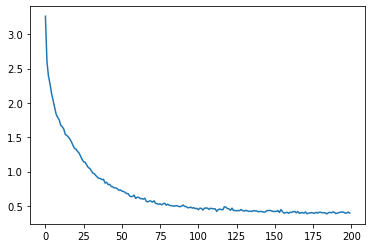

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [26]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter).title())

samples()

Adho Mukpa Nasana
Badrvanasana
Crataranga Dandasana


In [27]:
"$" + "yes"

'$yes'